# Imports

In [1]:
%pylab inline
import numpy as np
import scipy.io
import warnings

# Suppress the warning
warnings.filterwarnings("ignore", category=UserWarning)
from sklearn.metrics import accuracy_score
from matplotlib import mlab
import matplotlib.pyplot as plt
import scipy.signal 
from sklearn.model_selection import train_test_split,KFold
from sklearn.linear_model import LogisticRegression


Populating the interactive namespace from numpy and matplotlib


# Loading data

In [2]:
m = scipy.io.loadmat("E:\Downloads\BCICIV_1_mat\BCICIV_calib_ds1f.mat", struct_as_record=True)

In [3]:
sample_rate = m['nfo']['fs'][0][0][0][0]
EEG = m['cnt'].T
nchannels, nsamples = EEG.shape

In [4]:

channel_names = [s[0] for s in m['nfo']['clab'][0][0][0]]
event_onsets = m['mrk'][0][0][0]
event_codes = m['mrk'][0][0][1]
labels = np.zeros((1, nsamples), int)
labels[0, event_onsets] = event_codes #put 1 3nd l onsets

In [5]:
cl_lab = [s[0] for s in m['nfo']['classes'][0][0][0]]
cl1 = cl_lab[0] #left -1
cl2 = cl_lab[1] #right 1
nclasses = len(cl_lab)
nevents = len(event_onsets)

In [6]:
# Print some information
print('Shape of EEG:', EEG.shape)
print('Sample rate:', sample_rate)
print('Number of channels:', nchannels)
print('Channel names:', channel_names)
print('Number of events:', event_onsets.shape)
print('Event codes:', np.unique(event_codes))
print('Class labels:', cl_lab)
print('Number of classes:', nclasses)

Shape of EEG: (59, 190608)
Sample rate: 100
Number of channels: 59
Channel names: ['AF3', 'AF4', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'CFC7', 'CFC5', 'CFC3', 'CFC1', 'CFC2', 'CFC4', 'CFC6', 'CFC8', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T8', 'CCP7', 'CCP5', 'CCP3', 'CCP1', 'CCP2', 'CCP4', 'CCP6', 'CCP8', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'PO1', 'PO2', 'O1', 'O2']
Number of events: (1, 200)
Event codes: [-1  1]
Class labels: ['left', 'foot']
Number of classes: 2


# Preprocessing

In [7]:
# Dictionary to store the trials in, each class gets an entry
trials = {}

win = np.arange(int(0.5*sample_rate), int(2.5*sample_rate))
# Length of the time window
nsamples = len(win)
# Loop over the classes (right, left)
for cl, code in zip(cl_lab, np.unique(event_codes)):
    
    # Extract the onsets for the class
    cl_onsets = event_onsets[event_codes == code]
    
    # Allocate memory for the trials
    trials[cl] = np.zeros((nchannels, nsamples, len(cl_onsets)))
    # Extract each trial
    for i, onset in enumerate(cl_onsets):
        trials[cl][:,:,i] = EEG[:, win+onset]
        
# Some information about the dimensionality of the data (channels x time x trials)
print('Shape of trials[cl1]:', trials[cl1].shape)
print('Shape of trials[cl2]:', trials[cl2].shape)

Shape of trials[cl1]: (59, 200, 100)
Shape of trials[cl2]: (59, 200, 100)


In [8]:
def psd(trials):
   
    ntrials = trials.shape[2]
    trials_PSD = np.zeros((nchannels, 101, ntrials)) #(nsamples/2)+1

    # Iterate over trials and channels
    for trial in range(ntrials):
        for ch in range(nchannels):
            # Calculate the PSD
            (PSD, freqs) = mlab.psd(trials[ch,:,trial], NFFT=int(nsamples), Fs=sample_rate)
            trials_PSD[ch, :, trial] = PSD.ravel()
                
    return trials_PSD, freqs


In [9]:
psd_r, freqs = psd(trials[cl1])
psd_l, freqs = psd(trials[cl2])
trials_PSD = {cl1: psd_r, cl2: psd_l}


In [10]:

def plot_psd(trials_PSD, freqs, chan_ind, chan_lab=None, maxy=None):
 
    plt.figure(figsize=(12,5))
    
    nchans = len(chan_ind)
    
    # Maximum of 3 plots per row
    nrows = int(np.ceil(nchans / 3))
    ncols = min(3, nchans)
    
    # Enumerate over the channels
    for i,ch in enumerate(chan_ind):
        # Figure out which subplot to draw to
        plt.subplot(nrows,ncols,i+1)
    
        # Plot the PSD for each class
        for cl in trials.keys():
            plt.plot(freqs, np.mean(trials_PSD[cl][ch,:,:], axis=1), label=cl)
    
        
        plt.xlim(1,30)
        
        if maxy != None:
            plt.ylim(0,maxy)
    
        plt.grid()
    
        plt.xlabel('Frequency (Hz)')
        
        if chan_lab == None:
            plt.title('Channel %d' % (ch+1))
        else:
            plt.title(chan_lab[i])

        plt.legend()
        
    plt.tight_layout()

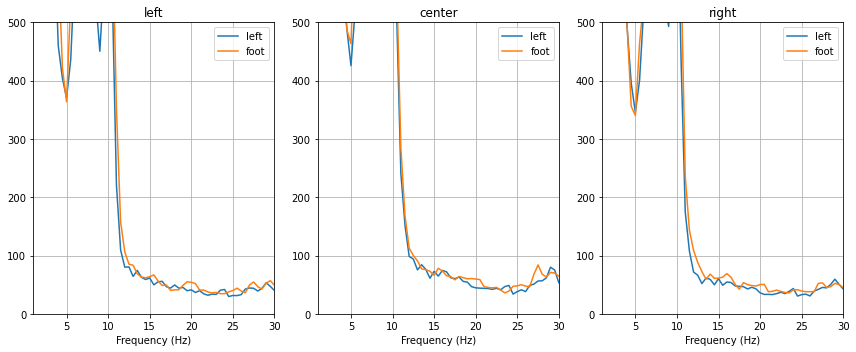

In [11]:
plot_psd(
    trials_PSD,
    freqs,
    [channel_names.index(ch) for ch in ['C3', 'Cz', 'C4']],
    chan_lab=['left', 'center', 'right'],
    maxy=500
)

In [12]:

def bandpass(trials, lo, hi, sample_rate):


    # The iirfilter() function takes the filter order: higher numbers mean a sharper frequency cutoff,
    # but the resulting signal might be shifted in time, lower numbers mean a soft frequency cutoff,
    # but the resulting signal less distorted in time. It also takes the lower and upper frequency bounds
    # to pass, divided by the niquist frequency, which is the sample rate divided by 2:
    a, b = scipy.signal.iirfilter(6, [lo/(sample_rate/2.0), hi/(sample_rate/2.0)]) 
 
    # Applying the filter to each trial
    ntrials = trials.shape[2]
    trials_filt = np.zeros((nchannels, nsamples, ntrials))
    for i in range(ntrials):
        trials_filt[:,:,i] = scipy.signal.filtfilt(a, b, trials[:,:,i], axis=1) #removing high-frequency noise from a signal
    
    return trials_filt

In [13]:
trials_filt = {cl1: bandpass(trials[cl1],8, 15, sample_rate),
               cl2: bandpass(trials[cl2], 8, 15, sample_rate)}

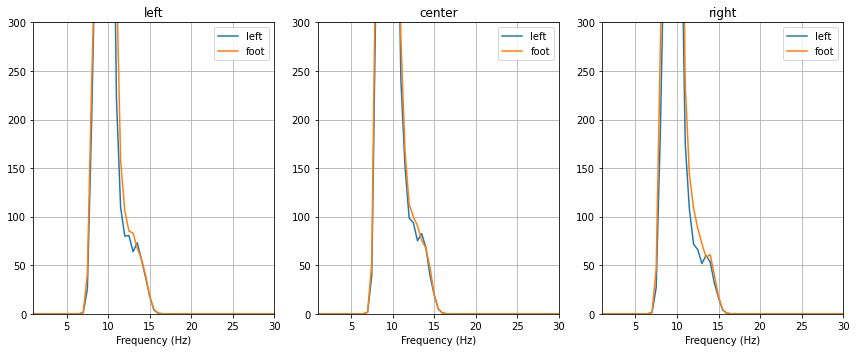

In [14]:
psd_r, freqs = psd(trials_filt[cl1])
psd_f, freqs = psd(trials_filt[cl2])
trials_PSD = {cl1: psd_r, cl2: psd_f}

plot_psd(
    trials_PSD,
    freqs,
    [channel_names.index(ch) for ch in ['C3', 'Cz', 'C4']],
    chan_lab=['left', 'center', 'right'],
    maxy=300
)

# Model

In [15]:
X1 = trials_filt[cl1]
X2 = trials_filt[cl2]
X = np.concatenate((X1, X2), axis=2)

# Flatten the data from 3D (channels x samples x trials) to 2D (samples x channels*trials)
nchannels, nsamples, ntrials = X.shape
X = X.reshape(nsamples, nchannels*ntrials)

# Create the labels for the two classes
y1 = np.ones(100)
y2 = np.zeros(100)

# Concatenate the labels for the two classes
y = np.concatenate((y1, y2))


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=True)

lr = LogisticRegression(solver='lbfgs')

# Use k-fold cross-validation to evaluate the model
kfold = KFold(n_splits=5)
scores = []
i=0
for train_index, val_index in kfold.split(X_train):
    i+=1
    X_train_fold, X_val = X_train[train_index], X_train[val_index]
    y_train_fold, y_val = y_train[train_index], y_train[val_index]
    lr.fit(X_train_fold, y_train_fold)
    y_pred_test = lr.predict(X_test)
    y_pred = lr.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    acc2=accuracy_score(y_test, y_pred_test)
    print('K= ',i,'val set accuracy:', acc, '  ,test set accuracy:', acc2)

K=  1 val set accuracy: 0.4375   ,test set accuracy: 0.3
K=  2 val set accuracy: 0.15625   ,test set accuracy: 0.325
K=  3 val set accuracy: 0.25   ,test set accuracy: 0.425
K=  4 val set accuracy: 0.40625   ,test set accuracy: 0.4
K=  5 val set accuracy: 0.28125   ,test set accuracy: 0.25


In [16]:
X1 = trials[cl1]
X2 = trials[cl2]
X = np.concatenate((X1, X2), axis=2)

# Flatten the data from 3D (channels x samples x trials) to 2D (samples x channels*trials)
nchannels, nsamples, ntrials = X.shape
X = X.reshape(nsamples, nchannels*ntrials)

# Create the labels for the two classes
y1 = np.ones(100)
y2 = np.zeros(100)

# Concatenate the labels for the two classes
y = np.concatenate((y1, y2))


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=True)

lr = LogisticRegression(solver='lbfgs')

# Use k-fold cross-validation to evaluate the model
kfold = KFold(n_splits=5)
scores = []
i=0
for train_index, val_index in kfold.split(X_train):
    i+=1
    X_train_fold, X_val = X_train[train_index], X_train[val_index]
    y_train_fold, y_val = y_train[train_index], y_train[val_index]
    lr.fit(X_train_fold, y_train_fold)
    y_pred_test = lr.predict(X_test)
    y_pred = lr.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    acc2=accuracy_score(y_test, y_pred_test)
    print('K= ',i,'val set accuracy:', acc, '  ,test set accuracy:', acc2)


K=  1 val set accuracy: 0.875   ,test set accuracy: 1.0
K=  2 val set accuracy: 0.9375   ,test set accuracy: 0.975
K=  3 val set accuracy: 1.0   ,test set accuracy: 1.0
K=  4 val set accuracy: 1.0   ,test set accuracy: 1.0
K=  5 val set accuracy: 0.875   ,test set accuracy: 0.95
